<a href="https://colab.research.google.com/github/tigureis/analise_dataset_campanha_marketing/blob/main/an%C3%A1lise_dataset_campanha_marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando Bibliotecas


---
Ciente de que não se trata de uma boa prática de programação, optei por importar as bibliotecas e as medidas utilizadas no código com o intuito de auxiliar em estudos futuros.


In [ ]:
import pandas as pd
import numpy as np
#import scipy.stats
#import seaborn as sns
#import plotly
#import xgboost
#import sklearn

Utilizando a função *pd.read* para importar o Data Frame

In [ ]:
MKT = pd.read_csv('MKT.csv')

Utilizando as funções *head*, *info* e *describe* para ter uma visão geral sobre os dados.

In [ ]:
MKT.head()

,youtube,facebook,newspaper,sales
0,84.72,19.20,48.96,12.60
1,351.48,33.96,51.84,25.68
2,135.48,20.88,46.32,14.28
3,116.64,1.80,36.00,11.52
4,318.72,24.00,0.36,20.88


In [ ]:
MKT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   youtube    171 non-null    float64
 1   facebook   171 non-null    float64
 2   newspaper  171 non-null    float64
 3   sales      171 non-null    float64
dtypes: float64(4)
memory usage: 5.5 KB


Verificou-se que os dados estão no formato correto (float) e não há dados vazios.

In [ ]:
MKT.describe()

,youtube,facebook,newspaper,sales
count,171.000000,171.000000,171.000000,171.000000
mean,178.021053,27.671579,35.240000,16.922807
std,102.449597,17.913532,24.902918,6.314608
min,0.840000,0.000000,0.360000,1.920000
25%,91.080000,11.700000,13.740000,12.540000
50%,179.760000,26.760000,31.080000,15.480000
75%,262.980000,43.680000,50.880000,20.820000
max,355.680000,59.520000,121.080000,32.400000


Analizando os valores, prezumie-se que os campos Youtube, Facebook e newspaper estejam em milhares enquanto o campo sale esteja em milhares de vendas ou em milhões vendidos, como não é especificado na descritiva, essa suposição não sera levada em conta na resolução

O campo 'newspaper' apresenta indícios da presença de outliers

Para confirmar essa suspeita, utilizou-se o gráfico de caixa ([box plot](https://plotly.com/python/box-plots/))

In [ ]:
from plotly.express import box
fig=box(MKT,x="newspaper")
fig.update_traces(line_color='red')

Para remover os outliers, utilizou-se da função [zscore](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html) em um processo iterativo. A cada iteração, os valores no campo 'newspaper' que excediam um limite predefinido de desvios padrão eram identificados e removidos. O processo continuava até que todos os dados estivessem dentro da faixa aceitável.

As alterações foram salvas em uma copia do DataFrame para preservar o original

In [ ]:
from scipy.stats import zscore
newMKT=MKT.copy()
outlID=[]
while True:
  outl = np.where(np.abs(np.abs(zscore(newMKT['newspaper']))) >3)[0].tolist()
  if not outl:
    break
  outlID.extend(outl)
  newMKT.drop(newMKT.index[list(outlID)], inplace=True)
  print("newspaper Outliers: ", outl)
  print("Total outlier newspaper: ", len(outl))
  outl.clear()
MKT.iloc[outlID, :]

newspaper Outliers:  [72]
Total outlier newspaper:  1
newspaper Outliers:  [46]
Total outlier newspaper:  1


,youtube,facebook,newspaper,sales
72,355.68,43.56,121.08,28.56
46,20.28,52.44,107.28,10.44


Confirmando com o [box plot](https://plotly.com/python/box-plots/) que não ha mais outliers.

In [ ]:
fig=box(newMKT,x="newspaper")
fig.update_traces(line_color='red')

Para visualizar as relações entre as variáveis, empregou-se a função [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html)

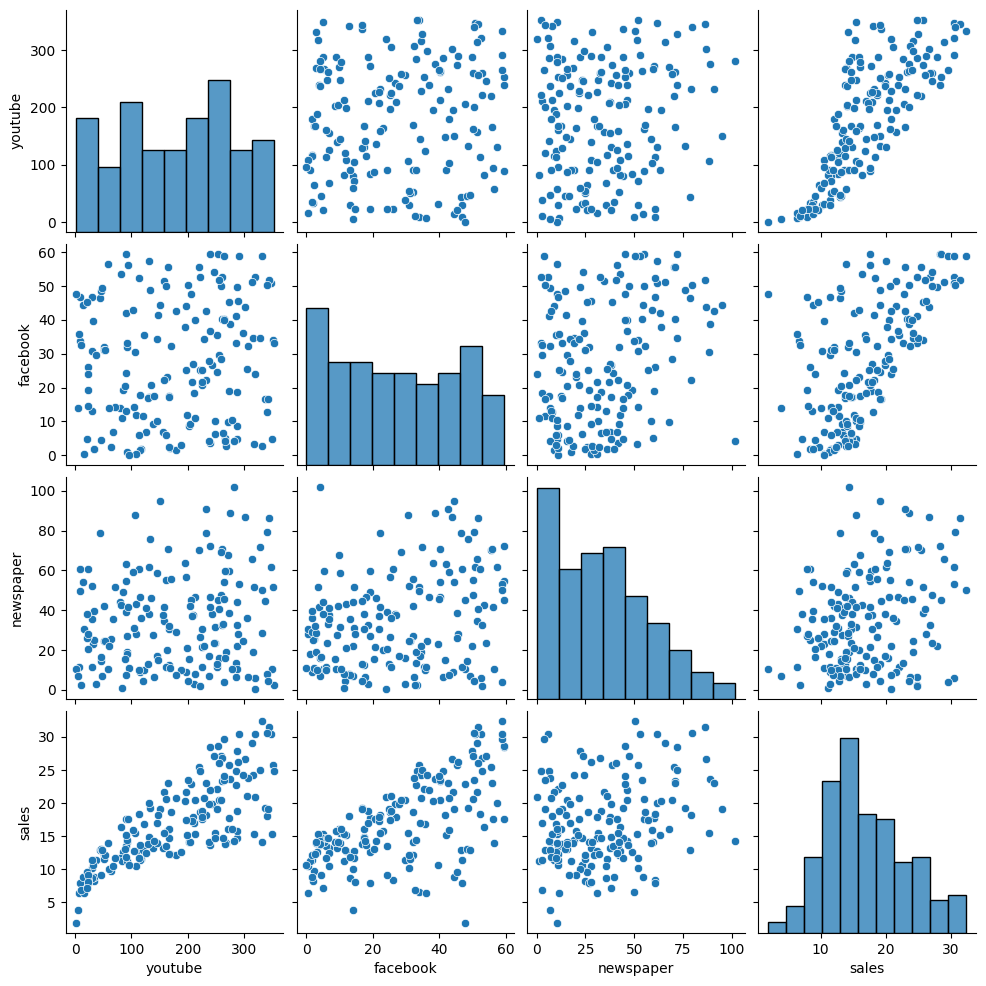

In [ ]:
from seaborn import pairplot as pp
pp(newMKT)

Os dados sugerem uma forte relação linear entre as variáveis 'youtube' e 'facebook' com a variável 'sales'. Em contraste, a relação entre 'newspaper' e 'sales' aparenta ser mais fraca

---

Com o objetivo de obter uma visão geral da força das relações entre as variáveis, recorreu-se à função [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

<Axes: >

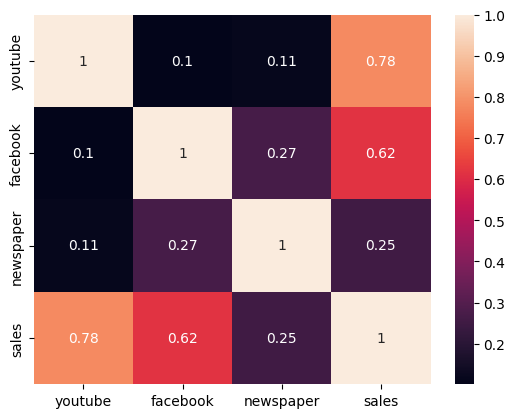

In [ ]:
from seaborn import heatmap
heatmap(newMKT.corr(),annot=True)

Após a confirmação das correlações, as variáveis 'youtube' e 'facebook' foram definidas como independentes (preditoras), e 'sales' como dependente (resposta). O impacto da variável 'newspaper' nos resultados do modelo será avaliado.

In [ ]:
X=newMKT[['youtube','facebook','newspaper']]
y=newMKT[['sales']]

Para preparar os dados para o treinamento e avaliação do modelo, utilizou-se a função [train_test_split](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.train_test_split.html), que dividiu o conjunto de dados em 80% para treinamento e 20% para teste

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

Empregou-se a função [LinearRegression](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LinearRegression.html) para criar um modelo de regressão linear. O modelo foi então treinado com os dados de treinamento e seu desempenho foi avaliado por meio das métricas [MSE](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.mean_squared_error.html) e [RMSE](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.root_mean_squared_error.html)."

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import mean_squared_error as mse
LinReg=LinearRegression()
LinReg.fit(X_train,y_train)
LR_MSE=mse(y_test,LinReg.predict(X_test))
LR_RMSE=rmse(y_test,LinReg.predict(X_test))


print(f'Utilizando o Metodo de Regressão Linear,\nMSE: {LR_MSE}\nRMSE: {LR_RMSE}')

Utilizando o Metodo de Regressão Linear,
MSE: 5.713161317987483
RMSE: 2.390222022739202


Construiu-se um novo conjunto de dados, representado pelas variáveis Xsn e ysn, para avaliar o desempenho de um modelo que exclui a variável 'newspaper'.

In [ ]:
Xsn=newMKT[['youtube','facebook']]
ysn=newMKT[['sales']]

Xsn_train, Xsn_test, ysn_train, ysn_test = train_test_split(Xsn,ysn,test_size=0.2,random_state=42)

LinReg_sn=LinearRegression()
LinReg_sn.fit(Xsn_train,ysn_train)

LR_MSE_sn=mse(ysn_test,LinReg_sn.predict(Xsn_test))
LR_RMSE_sn=rmse(ysn_test,LinReg_sn.predict(Xsn_test))

print(f'Utilizando o Metodo de Regressão Linear, sem incluir os dados de Newspaper \nMSE: {LR_MSE_sn}\nRMSE: {LR_RMSE_sn}')

Utilizando o Metodo de Regressão Linear, sem incluir os dados de Newspaper 
MSE: 6.728627244169355
RMSE: 2.5939597614784535


Verificou-se uma perda de resultados mse muito pequena, porem não houve ganho computacional siguinificativo, a variavel ser testada novamente caso encontre-se um modelo de predição mais eficiente

---



Experimentando com o método [SVR](https://scikit-learn.org/1.5/modules/generated/sklearn.svm.SVR.html) e analisando seu desempenho

In [ ]:
from sklearn.svm import SVR
SVR_model = SVR().fit(X_train, y_train.values.ravel())
y_SRV=SVR_model.predict(X_test)
SVR_MSE=mse(y_test,y_SRV)
SVR_RMSE=rmse(y_test,y_SRV)

print(f'Utilizando o Método de Regressão de Vetor de Suporte\nMSE: {SVR_MSE}\nRMSE: {SVR_RMSE}')


Utilizando o Método de Regressão de Vetor de Suporte
MSE: 8.951399294383993
RMSE: 2.9918889174539873


Resultados muito inferiores aos testados anteriores. metodo descontinuado.

---



Experimentando com o método [XGBoost](https://xgboost.readthedocs.io/en/stable/) e analisando seu desempenho


In [ ]:
from xgboost import XGBRegressor
SGB_Reg = XGBRegressor().fit(X_train,y_train)
ySGB = SGB_Reg.predict(X_test)
XGB_MSE=mse(y_test,ySGB)
XGB_RMSE=rmse(y_test,ySGB)

print(f'Utilizando o Método XGBoost\nMSE: {XGB_MSE}\nRMSE: {XGB_RMSE}')

Utilizando o Método XGBoost
MSE: 1.0664025325207263
RMSE: 1.0326676776779287


verifica-se que o xgboost oferece o melhor resultado ate o momento

---



Analisando o desempenho do modelo XGBoost após a exclusão da variável 'newspaper'.

In [ ]:
SGB_sn = XGBRegressor().fit(Xsn_train,ysn_train)
ySGB_sn = SGB_sn.predict(Xsn_test)
XGB_MSE_sn=mse(ysn_test,ySGB_sn)
XGB_RMSE_sn=rmse(ysn_test,ySGB_sn)

print(f'Utilizando o Método XGBoost, sem a variavel newspaper\nMSE: {XGB_MSE_sn}\nRMSE: {XGB_RMSE_sn}')

Utilizando o Método XGBoost, sem a variavel newspaper
MSE: 0.9530554946996057
RMSE: 0.9762456118721383


Os resultados do MSE e RMSE demonstram que a remoção da variável 'newspaper' contribui para um modelo mais preciso.

---



Para fundamentar a decisão de remover a variável 'newspaper', que aparentava estar degradando a performance do modelo XGBoost, avaliou-se seu desempenho individual como preditora.

In [ ]:

Xnp_train, Xnp_test, ynp_train, ynp_test = train_test_split(X['newspaper'],y,test_size=0.2,random_state=42)
SGB_model_np = XGBRegressor().fit(Xnp_train,ynp_train)
ySGB_np = SGB_model_np.predict(Xnp_test)
XGB_MSE_np=mse(ynp_test,ySGB_np)
XGB_RMSE_np=rmse(ynp_test,ySGB_np)

print(f'Utilizando o Método XGBoost, na variavel newspaper isolada\nMSE: {XGB_MSE_np}\nRMSE: {XGB_RMSE_np}')


Utilizando o Método XGBoost, na variavel newspaper isolada
MSE: 72.20120238033735
RMSE: 8.497129066945927


Diante dos resultados que indicaram um impacto negativo da variável 'newspaper' no desempenho do modelo, optou-se por prosseguir com o treinamento utilizando apenas as variáveis 'youtube' e 'facebook' como preditoras.

---



Definido o modelo e as variaveis, utiliza-se a função [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) para encontrar os melhores parametros para o treinamento do modelo

In [ ]:
from sklearn.model_selection import GridSearchCV

Definindo os hiperparametros a serem testados

In [ ]:
parameters={
    "gamma" : [0, 0.1, 0.01],
    "learning_rate" : [0.01, 0.1 , 0.3],
    "max_delta_step" : [0],
    "max_depth" : [5, 6],
    "min_child_weight" : [0, 0.1, 1],
    "n_jobs" : [5],
    "subsample" : [0.5],
}

Para encontrar a melhor configuração para o modelo, o treinamento foi realizado com todas as combinações de hiperparâmetros definidas no espaço de busca.

In [ ]:
XGB_sn=GridSearchCV(XGBRegressor(),parameters,  verbose=True)
rgb_grid_model_sn=XGB_sn.fit(Xsn_train,ysn_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


O modelo foi treinado com os hiperparâmetros otimizados e as métricas MSE e RMSE foram calculadas para avaliar seu desempenho

In [ ]:
rgb_grid_model_sn.best_params_


{'gamma': 0.01,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 0,
 'n_jobs': 5,
 'subsample': 0.5}

Com os hiperparâmetros ajustados por meio do GridSearchCV, o modelo foi treinado e avaliado utilizando as métricas MSE e RMSE, a fim de verificar a melhoria no desempenho em relação ao modelo anterior.

In [ ]:
ysn_Grid=rgb_grid_model_sn.predict(Xsn_test)
MSEGrid_sn=mse(ysn_test,ysn_Grid)
RMSEGrid_sn=rmse(ysn_test,ysn_Grid)

print(f'Using the XGBoost with the best model,\nMSE: {MSEGrid_sn}\nRMSE: {RMSEGrid_sn}')

Using the XGBoost with the best model,
MSE: 1.0108128592766659
RMSE: 1.0053918933812158


Com base no desempenho promissor demonstrado pelo XGBoost em termos de MSE, selecionamos os três que utilizaram  esse método testar e comparar as predições, buscando identificar a melhor configuração para o problema em questão.

In [ ]:
invest_youtube=float(input("valor Youtube: "))
invest_facebook=float(input("valor Facebook: "))
invest_newspaper=float(input("valor Newspaper: "))

entrada = pd.DataFrame({'youtube': [invest_youtube], 'facebook': [invest_facebook], 'newspaper':[invest_newspaper]})
entrada_sn = pd.DataFrame( {'youtube': [invest_youtube], 'facebook': [invest_facebook]})

print (f"Utilizando o metodo XGBoost, com todas as variaveis: \nPara um investimento em: \nYoutube = {invest_youtube} \nFacebook = {invest_facebook} \nnewspaper = {invest_newspaper} \nTeremos uma venda de: {SGB_Reg.predict(entrada)}\n\n")
print (f"Utilizando o metodo XGBoost, sem a variavel newspaper: \nPara um investimento em: \nYoutube = {invest_youtube} \nFacebook = {invest_facebook} \nTeremos uma venda de: {SGB_sn.predict(entrada[['youtube','facebook']])}\n\n")
print (f"Utilizando o metodo XGBoost, após refinamento sem a variavel newspaper: \nPara um investimento em: \nYoutube = {invest_youtube} \nFacebook = {invest_facebook} \nTeremos uma venda de: {rgb_grid_model_sn.predict(entrada_sn)}\n\n")

valor Youtube: 100
valor Facebook: 100
valor Newspaper: 100
Utilizando o metodo XGBoost, com todas as variaveis: 
Para um investimento em: 
Youtube = 100.0 
Facebook = 100.0 
newspaper = 100.0 
Teremos uma venda de: [18.053679]


Utilizando o metodo XGBoost, sem a variavel newspaper: 
Para um investimento em: 
Youtube = 100.0 
Facebook = 100.0 
Teremos uma venda de: [17.914978]


Utilizando o metodo XGBoost, após refinamento sem a variavel newspaper: 
Para um investimento em: 
Youtube = 100.0 
Facebook = 100.0 
Teremos uma venda de: [18.443213]




Na etapa de avaliação do projeto, ao intensificar os parâmetros do modelo, percebeu-se que a variável alvo não respondia de forma proporcional, sugerindo um possível overfitting

---



Para investigar a suspeita de overfitting, visualizou-se o comportamento dos modelos por meio de gráficos. Para isso, fixou-se duas variáveis em seus valores médios e variou-se uma terceira entre 0 e 500, observando-se a resposta da variável alvo.

---

Após a confirmação do overfitting nos modelos iniciais, a mesma análise gráfica foi aplicada aos modelos de Regressão Linear, com e sem a variável 'newspaper', para avaliar seu desempenho em comparação.

In [ ]:
youtubevar_xgboost_fullvar=[]
facebookvar_xgboost_fullvar=[]
newspapervar_xgboost_fullvar=[]
youtubevar_xgboost_sn=[]
facebookvar_xgboost_sn=[]
youtubevar_xgboost_refined=[]
facebookvar_xgboost_refined=[]
youtubevar_lin_alg_fullvar=[]
facebookvar_lin_alg_fullvar=[]
newspapervar_lin_alg_fullvar=[]
youtubevar_lin_alg_sn=[]
facebookvar_lin_alg_sn=[]


for i in range(501):
  entrada_youtube = pd.DataFrame({'youtube': [i], 'facebook': [28], 'newspaper': [35]})
  entrada_facebook = pd.DataFrame({'youtube': [178], 'facebook': [i], 'newspaper': [35]})
  entrada_newspaper = pd.DataFrame({'youtube': [178], 'facebook': [28], 'newspaper': [i]})
  youtubevar_xgboost_fullvar.append(SGB_Reg.predict(entrada_youtube))
  facebookvar_xgboost_fullvar.append(SGB_Reg.predict(entrada_facebook))
  newspapervar_xgboost_fullvar.append(SGB_Reg.predict(entrada_newspaper))
  youtubevar_xgboost_sn.append(SGB_sn.predict(entrada_youtube[['youtube','facebook']]))
  facebookvar_xgboost_sn.append(SGB_sn.predict(entrada_facebook[['youtube','facebook']]))
  youtubevar_xgboost_refined.append(rgb_grid_model_sn.predict(entrada_youtube[['youtube','facebook']]))
  facebookvar_xgboost_refined.append(rgb_grid_model_sn.predict(entrada_facebook[['youtube','facebook']]))
  youtubevar_lin_alg_fullvar.append(LinReg.predict(entrada_youtube)[0])
  facebookvar_lin_alg_fullvar.append(LinReg.predict(entrada_facebook)[0])
  newspapervar_lin_alg_fullvar.append(LinReg.predict(entrada_newspaper)[0])
  youtubevar_lin_alg_sn.append(LinReg_sn.predict(entrada_youtube[['youtube','facebook']])[0])
  facebookvar_lin_alg_sn.append(LinReg_sn.predict(entrada_facebook[['youtube','facebook']])[0])

A biblioteca [matplotlib](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html) foi utilizada para gerar os gráficos, plotando os pontos obtidos nas variações dos investimentos

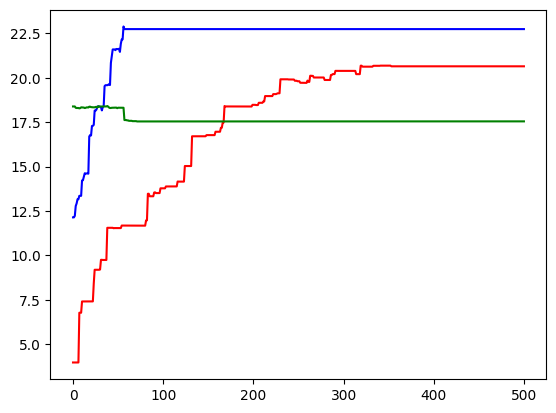

In [ ]:
import matplotlib.pyplot as plt
plt.plot(youtubevar_xgboost_fullvar, 'r', facebookvar_xgboost_fullvar, 'b', newspapervar_xgboost_fullvar, 'g')
plt.show()


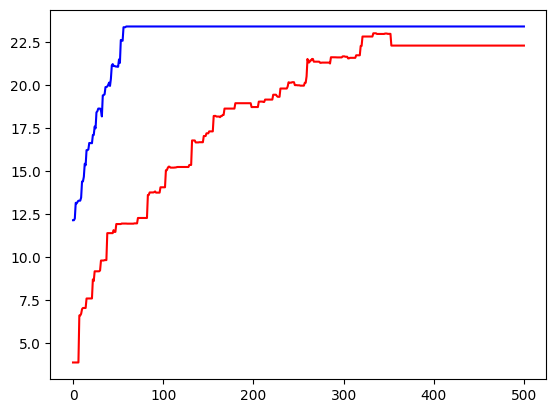

In [ ]:
plt.plot(youtubevar_xgboost_sn, 'r', facebookvar_xgboost_sn, 'b')
plt.show()

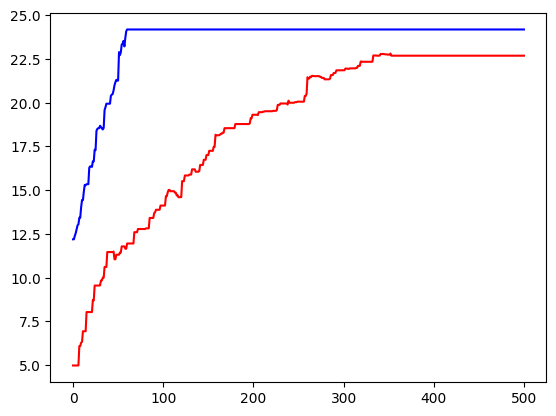

In [ ]:
plt.plot(youtubevar_xgboost_refined, 'r', facebookvar_xgboost_refined, 'b')
plt.show()

A análise dos gráficos revelou um claro overfitting nos modelos.

---

Após a constatação de overfitting nos modelos anteriores, a atenção foi direcionada para a análise dos modelos de Regressão Linear, com o objetivo de verificar se estes apresentavam um comportamento mais robusto

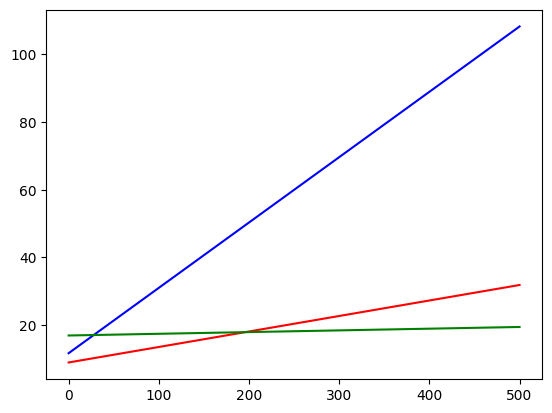

Para um investimento de 0 temos um retorno de: [16.90712577] 
Para um investimento de 500 temos um retorno de: [19.42522395] 
podemos calcular então uma taxa de variação do modelo de: [0.00502614]


In [ ]:
plt.plot(youtubevar_lin_alg_fullvar, 'r', facebookvar_lin_alg_fullvar, 'b', newspapervar_lin_alg_fullvar, 'g')
plt.show()

A análise inicial indicou que a variação do investimento em 'newspaper' não apresentava um impacto significativo no resultado. Para aprofundar a investigação, o modelo foi executado considerando apenas o investimento em 'newspaper', variando-o de 0 a 500, a fim de observar seu efeito isolado

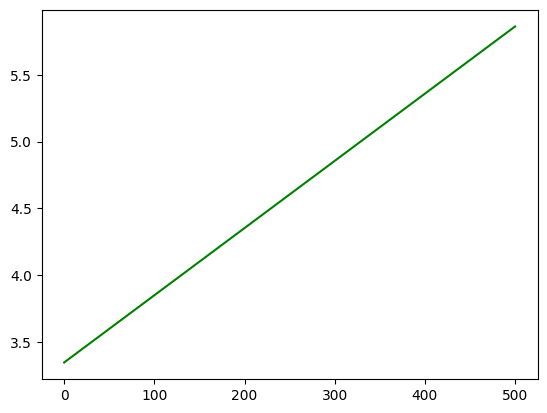

Para um investimento de 0 temos um retorno de: [3.34474566] 
Para um investimento de 500 temos um retorno de: [5.86284384] 
podemos calcular então uma taxa de variação do modelo de: [0.00502614]


In [ ]:
newspapervar_lin_alg_fullvar=[]
for i in range(501):
  entrada_newspaper = pd.DataFrame({'youtube': [0], 'facebook': [0], 'newspaper': [i]})
  newspapervar_lin_alg_fullvar.append(LinReg.predict(entrada_newspaper)[0])

plt.plot(newspapervar_lin_alg_fullvar, 'g')
plt.show()
print(f"Para um investimento de 0 temos um retorno de: {newspapervar_lin_alg_fullvar[0]} \nPara um investimento de {len(newspapervar_lin_alg_fullvar)-1} temos um retorno de: {newspapervar_lin_alg_fullvar[-1]} ")
print(f"podemos calcular então uma taxa de variação do modelo de: {(newspapervar_lin_alg_fullvar[-1]-newspapervar_lin_alg_fullvar[0])/len(newspapervar_lin_alg_fullvar)}")

Plotando a variável newspaper isoladamente, podemos perceber que esta não é insignificante, mas tem impacto ínfimo no resultado final

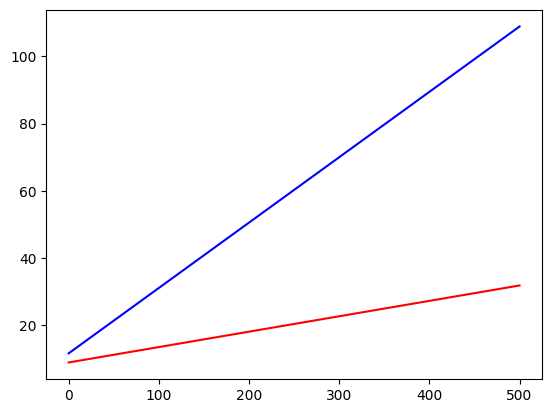

Utilizando o Metodo de Regressão Linear,
MSE: 5.713161317987483
RMSE: 2.390222022739202
Utilizando o Metodo de Regressão Linear, sem incluir os dados de Newspaper 
MSE: 6.728627244169355
RMSE: 2.5939597614784535


In [ ]:
plt.plot(youtubevar_lin_alg_sn,'r',facebookvar_lin_alg_sn, 'b')
plt.show()
print(f'Utilizando o Metodo de Regressão Linear,\nMSE: {LR_MSE}\nRMSE: {LR_RMSE}')
print(f'Utilizando o Metodo de Regressão Linear, sem incluir os dados de Newspaper \nMSE: {LR_MSE_sn}\nRMSE: {LR_RMSE_sn}')

O modelo de regressão linear se mostrou o mais indicado para a aplicação. Apesar da pequena melhora nas métricas MSE e RMSE, sugere-se a utilização do modelo que inclui os dados de 'newspaper'.

In [ ]:
invest_youtube=float(input("valor Youtube: "))
invest_facebook=float(input("valor Facebook: "))
invest_newspaper=float(input("valor Newspaper: "))

entrada = pd.DataFrame({'youtube': [invest_youtube], 'facebook': [invest_facebook], 'newspaper':[invest_newspaper]})
result=LinReg.predict(entrada)[0]
print (f"Utilizando o metodo de Regressão Linear com os investimentos informados teremos uma venda de: {result}\n\n")

valor Youtube: 100
valor Facebook: 20
valor Newspaper: 0
Utilizando o metodo de Regressão Linear com os investimentos informados teremos uma venda de: [11.78884664]




# Resultados


---

Desempenho do Modelo:

Para a quantidade de dados disponível, o modelo que apresentou o melhor desempenho foi a regressão linear simples. Este modelo se comporta de forma excelente para valores de entrada (inputs) entre 0 e 300, demonstrando boa capacidade preditiva dentro dessa faixa. É importante ressaltar que, como não há dados para investimentos fora dessa faixa, não podemos prever com segurança como o modelo se comportará nesses cenários

Recomendações:

Considerando a quantidade limitada de dados utilizada no treinamento, recomenda-se a utilização do modelo de regressão linear simples, com acompanhamento constante dos erros de predição. É crucial continuar coletando dados para aprimorar o modelo e avaliar a possibilidade de migrar para modelos mais complexos, como os que oferecem menor R², quando houver dados suficientes para garantir um treinamento mais robusto.

Insights sobre Investimentos:

A análise dos dados indica que o investimento em Facebook se mostrou o mais interessante, com maior impacto nas vendas. Por outro lado, os investimentos em newspaper apresentaram retornos muito baixos, sugerindo que este investimento deveria ser reduzido ou descontinuado para otimizar a alocação de recursos.